# Urban effects on FPS-SESA simulations


Let's first have a look at the urban fraction as seen by the model. This is land use type 13 (Urban and built-up) in MODIS data.

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import cm
from os.path import exists

ProgressBar().register()

MODIS_LAND_USE = {
  'Urban and built-up': 13,
  'Water bodies': 17
}

## Static fields

In [4]:
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/fx/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx'
ds = xr.open_dataset(url)

This loaded all fixed variables information into `ds`. Variables can be accessed as attributes of this object. E.g. land use:

In [3]:
ds.landuse

<xarray.DataArray 'landuse' (lat: 451, lon: 676)>
[304876 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat      (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
Attributes:
    standard_name:  land_cover
    long_name:      Land Cover
    units:          1
    cell_methods:   time: point
    _ChunkSizes:    [50 50]

This is how the common spatial domain looks like (this operation takes some time since some data needs to be retrieved):

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


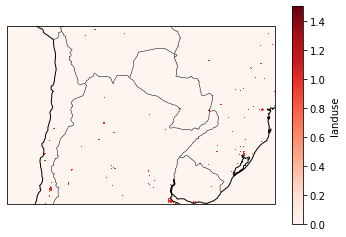

In [5]:
p = (ds.landuse == MODIS_LAND_USE['Urban and built-up']).plot(
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.Reds, vmax = 1.5
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

This is remapped to the regular lon-lat grid. The original extent of the cities is quite similar and in the rotated grid cities such as Buenos Aires are inside the domain. The following code would show it.
```python
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/ncml/CORDEX/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/fx/v20220727/CORDEX_output_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx_v20220727'
ds = xr.open_dataset(url)
proj = ccrs.RotatedPole(
  pole_longitude=ds.rotated_pole.grid_north_pole_longitude+180,
  pole_latitude=ds.rotated_pole.grid_north_pole_latitude
)
p = (ds.landuse == MODIS_LAND_USE['Urban and built-up']).plot(x='lon', y='lat',
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=proj),
    cmap = cm.viridis_r
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)
```

Major rivers and lakes are also seen by the model at this resolution.

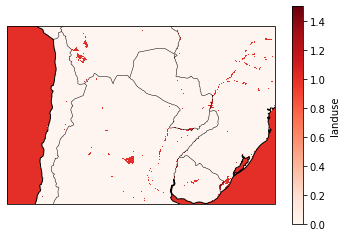

In [5]:
p = (ds.landuse == MODIS_LAND_USE['Water bodies']).plot(
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.Reds, vmax = 1.5
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

## Analysis of minimum temperatures

See https://github.com/jesusff/city_detect/blob/main/RCM_urban_effects.ipynb

In [6]:
var = 'tasmin'
city = 'Buenos Aires'

location = {
  'Buenos Aires': dict(lon=-58.66, lat=-34.49),
  'Porto Alegre': dict(lon=-51.17, lat=-30.03),
}
dlon = dlat = 13

urls = {
  'UCAN-WRF433' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/day/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_day',
  'USP-RegCM471' : 
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4i/USP/ECMWF-ERA5/historical/r1i1p1f1/USP-RegCM471/v0/day/CORDEX_output_CSAM-4i_ECMWF-ERA5_historical_r1i1p1f1_USP-RegCM471_v0_day', 
  'ERA5' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/reanalysis/ERA5-CSAM-4i_day',
  'MSWX' :
     'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/observations/CSAM-4i_GloH2O-MSWX_day'
}

def load_city(nc, url, var, scale = 1.0):
  if exists(nc):
    rval = xr.open_dataset(nc)
    print(f'Data loaded from cache: {nc}')
  else:
    if type(url) == type([]):
      ds = xr.open_mfdataset(url, chunks = {'lon': 10, 'lat': 10})
    else:
      ds = xr.open_dataset(url, chunks = {'lon': 10, 'lat': 10})
      ilon = np.argmin((ds['lon'].values-location[city]['lon'])**2)
      ilat = np.argmin((ds['lat'].values-location[city]['lat'])**2)
      rval = ds.isel(
        lat = slice(ilat-dlat,ilat+dlat),
        lon = slice(ilon-dlon,ilon+dlon)
      ).compute()
    rval.to_netcdf(nc, format = 'NETCDF4', encoding={var:{'zlib':True}})
  return(rval)   

def index_average_n_highest(ds, n = 10):
  ''' Average of n days with the largest tasmin on the city
  
  Averages spatial anomalies with respect to this maximum tasmin
  '''
  rval = (ds[var].isel(time = (ds[var]
    .isel(**{'lon': dlon, 'lat': dlat})
    .argsort()[::-1][:n] # take the n highest
    .values
  )))
  rval = rval - rval.isel(**{'lon': dlon, 'lat': dlat}).values[:,None,None]
  rval = rval.mean(dim='time')
  return(rval)

 ** UCAN-WRF433
Data loaded from cache: tasmin_UCAN-WRF433_Buenos-Aires.nc


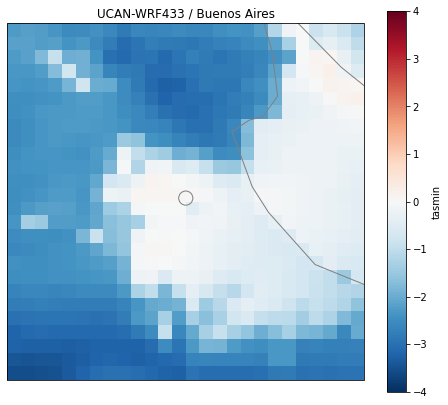

 ** USP-RegCM471
Data loaded from cache: tasmin_USP-RegCM471_Buenos-Aires.nc


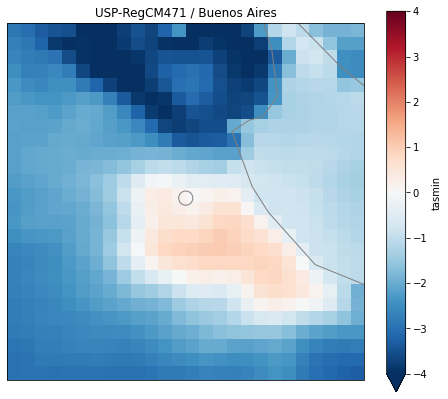

 ** ERA5
Data loaded from cache: tasmin_ERA5_Buenos-Aires.nc


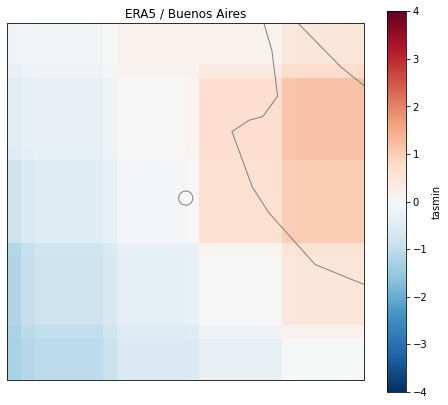

 ** MSWX
Data loaded from cache: tasmin_MSWX_Buenos-Aires.nc


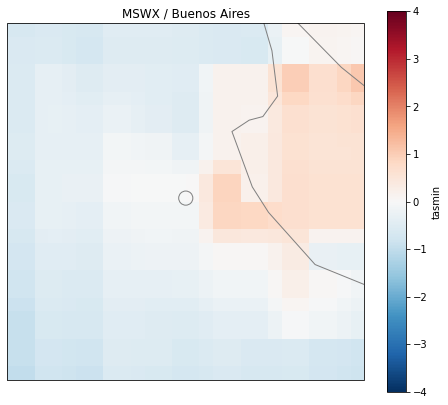

In [11]:
for dataset in ['UCAN-WRF433', 'USP-RegCM471', 'ERA5', 'MSWX']:
  print(f' ** {dataset}')
  pcity = city.replace(' ','-')
  ds_city = load_city(f'{var}_{dataset}_{pcity}.nc', urls[dataset], var)
  index = index_average_n_highest(ds_city)
  proj = ccrs.PlateCarree()
  lonlat = ccrs.PlateCarree()
  f = plt.figure(figsize=(8,7))
  ax = plt.axes(projection=proj)
  index.plot.pcolormesh(
    ax=ax, transform=lonlat, cmap=plt.cm.RdBu_r, vmax=4
  )
  plt.title(f'{dataset} / {city}')
  ax.coastlines(resolution='50m', linewidth=1, color='gray')
  ax.scatter(location[city]['lon'], location[city]['lat'], transform=lonlat, s=200, facecolor='none', edgecolor='grey')
  f.savefig(f'{dataset}_{pcity}.png', facecolor='white')
  plt.show()
  plt.close('all')